# eXtreme Gradient Boosting (XGB) Model, Trained on Limited Dataset
## Model Dataset Limited by SOCAT Sampling Locations

In [38]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Python file with supporting functions
import model_utils

In [39]:
recon_model_path = '/home/julias/MLEE-final-project/models/saved_models/recon_models'

### To Set and Track Seeds for Reproducibility (Referencing Group Standard):

In [40]:
ens = 'CESM'
member = '009'
reference_output_dir = '/home/julias/MLEE-final-project/pickle_files'

path_seeds = f'{reference_output_dir}/random_seeds.npy'
random_seeds = np.load(path_seeds)  

path_loc = f'{reference_output_dir}/cesm_seed_loc_dict.pickle'
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)
seed_loc = seed_loc_dict[ens][member]

# for next project, where train and test datasets use all CESM members
#path_cesm = f"{reference_output_dir}/cesm_members_dict.pickle"
#with open(path_cesm,'rb') as handle:
#    cesm_mems_dict = pickle.load(handle)

In [41]:
# random_seeds

In [ ]:
# seed_loc_dict # using CESM 009, so seed_loc should be 32

In [ ]:
# seed_loc #confirmed 32

# Load Split Datasets

In [73]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

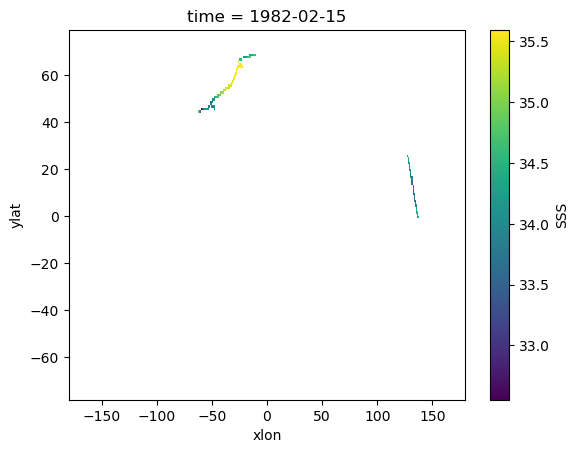

In [74]:
X_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').SSS[0,:,:].plot()

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

ALSO note, done after the above test on original dataframes because method overwrites original dataframes, need to debug this

In [ ]:
#X_df_norm = (X_df - X_df.mean())/X_df.std() 
#y_df_norm = (y_df - y_df.mean())/y_df.std()
#X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
#y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
#X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
#y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

# Preliminary XGB Models

***Goal: Compare auto-XGB with lowest end and highest end of group XGB parameter matrix***

## Baseline Model Test

Alternations should at least improve on the baseline set by the auto-generated XGB algorithm

In [8]:
model_baseline = xgb.XGBRegressor(verbosity=0) 

In [9]:
model_baseline.fit(X_train_df, y_train_df)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Learning rate looks high, may need to manually set

In [10]:
train_score_baseline = model_baseline.score(X_train_df, y_train_df) 
train_score_baseline

0.9513665434481153

In [11]:
test_score_baseline = model_baseline.score(X_test_df, y_test_df) 
test_score_baseline

0.9163440706104468

In [12]:
y_pred_baseline = model_baseline.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_baseline)
print("MSE: %.2f" % mse)

MSE: 134.11


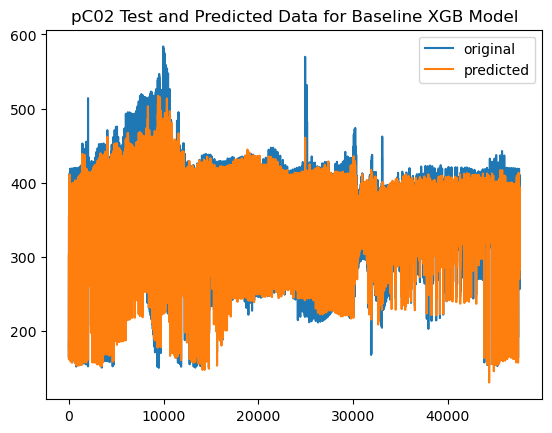

In [14]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_baseline, label="predicted")
plt.title("pC02 Test and Predicted Data for Baseline XGB Model")
plt.legend()
plt.show()

In [ ]:
y_test_df_norm['baseline_XGB_pred'] = y_pred_baseline

In [ ]:
y_test_df_norm.baseline_XGB_pred

In [ ]:
y_test_df = y_test_df.pCO2

In [ ]:
y_test_df

In [15]:
joblib.dump(model_baseline, os.path.join(recon_model_path,'XGB_prelim_baseline.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_baseline.h5']

In [16]:
baseline_load_test = joblib.load(os.path.join(recon_model_path,'XGB_prelim_baseline.h5'))

In [17]:
baseline_load_test.score(X_train_df, y_train_df)

0.9513665434481153

## Lowest Combination of XGB Parameter Matrix

In [18]:
model_low = XGBRegressor(n_estimators=3000, max_depth=5) #if want to set learning rate, eta: "often set to small values such as 0.3, 0.1, 0.01, or smaller"
model_low.fit(X_train_df, y_train_df) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [19]:
joblib.dump(model_low, os.path.join(recon_model_path,'XGB_prelim_lowest_param.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_lowest_param.h5']

In [75]:
model_low = joblib.load(os.path.join(recon_model_path,'XGB_prelim_lowest_param.h5'))

In [21]:
train_score_low = model_low.score(X_train_df, y_train_df) 
train_score_low

0.9937757645578723

In [22]:
test_score_low = model_low.score(X_test_df, y_test_df) 
test_score_low

0.9367673550262187

In [76]:
y_pred_low = model_low.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_low)
print("MSE: %.2f" % mse)

MSE: 101.37


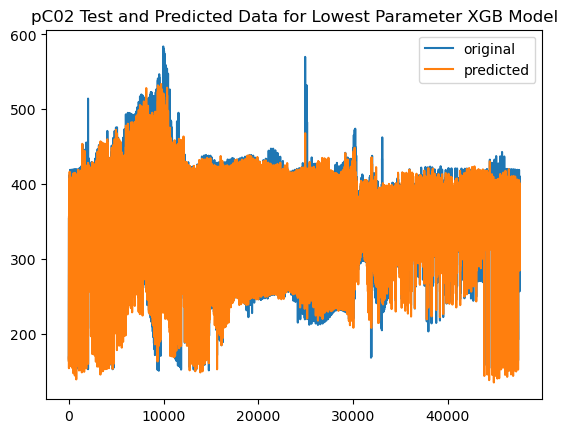

In [27]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_low, label="predicted")
plt.title("pC02 Test and Predicted Data for Lowest Parameter XGB Model")
plt.legend()
plt.show()

## Highest Combination of XGB Parameter Matrix

In [25]:
model_high = XGBRegressor(n_estimators=5000, max_depth=8)
model_high.fit(X_train_df, y_train_df) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [26]:
joblib.dump(model_high, os.path.join(recon_model_path,'XGB_prelim_highest_param.h5')) 

['/home/julias/MLEE-final-project/models/saved_models/recon_models/XGB_prelim_highest_param.h5']

In [77]:
model_high = joblib.load(os.path.join(recon_model_path,'XGB_prelim_highest_param.h5'))

In [29]:
train_score_high = model_high.score(X_train_df, y_train_df) 
train_score_high

0.9999247559832833

In [30]:
test_score_high = model_high.score(X_test_df, y_test_df) 
test_score_high

0.9371849899281297

In [78]:
y_pred_high = model_high.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_high)
print("MSE: %.2f" % mse)

MSE: 100.70


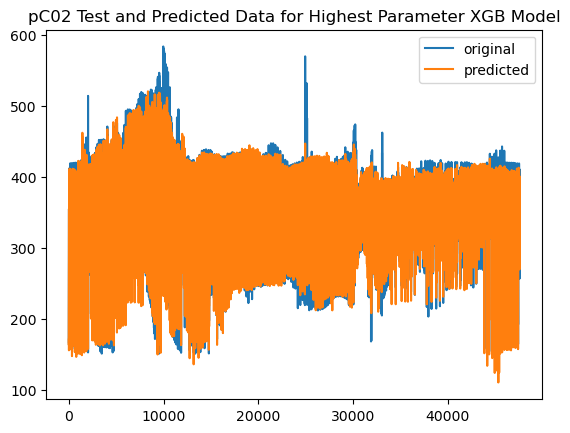

In [32]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_high, label="predicted")
plt.title("pC02 Test and Predicted Data for Highest Parameter XGB Model")
plt.legend()
plt.show()

# Create Analysis Plots

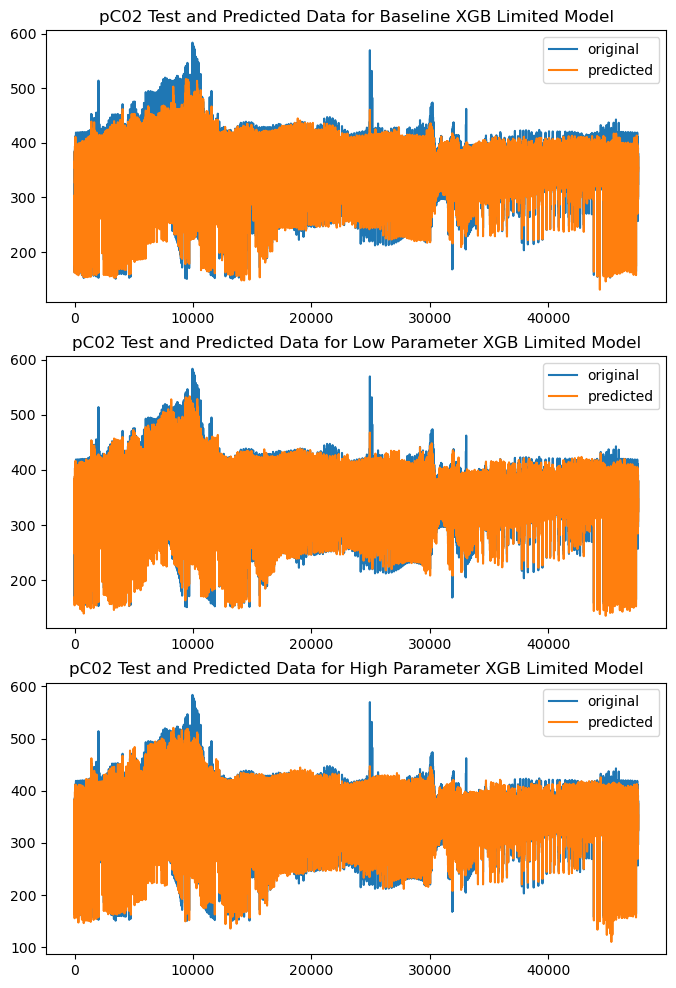

In [80]:
fig, ax = plt.subplots(nrows=3, figsize=(8,12)) 

r1 = range(len(y_test_df))
ax[0].plot(r1, y_test_df, label="original")
ax[0].plot(r1, y_pred_baseline, label="predicted")
ax[0].set_title("pC02 Test and Predicted Data for Baseline XGB Limited Model")
ax[0].legend()

r2 = range(len(y_test_df))
ax[1].plot(r2, y_test_df, label="original")
ax[1].plot(r2, y_pred_low, label="predicted")
ax[1].set_title("pC02 Test and Predicted Data for Low Parameter XGB Limited Model")
ax[1].legend()

r3 = range(len(y_test_df))
ax[2].plot(r3, y_test_df, label="original")
ax[2].plot(r3, y_pred_high, label="predicted")
ax[2].set_title("pC02 Test and Predicted Data for High Parameter XGB Limited Model")
ax[2].legend()

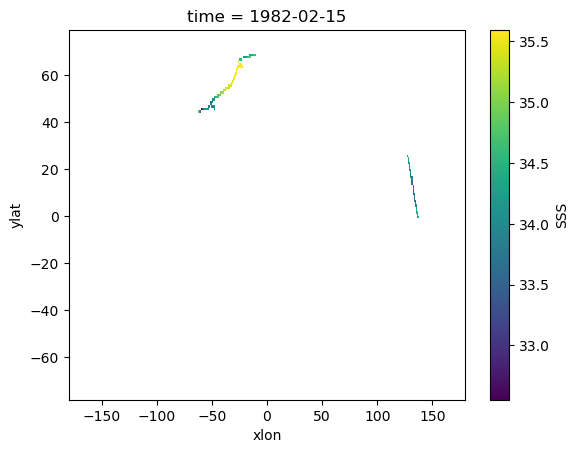

In [81]:
X_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').SSS[0,:,:].plot()

In [82]:
y_test_df['baseline_pred'] = y_pred_baseline
y_test_df['low_pred'] = y_pred_low
y_test_df['high_pred'] = y_pred_high

y_comparison = y_test_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')

Text(0.5, 1.0, 'pC02 Predicted Data in September 2016 \n for High Parameter XGB Limited Model')

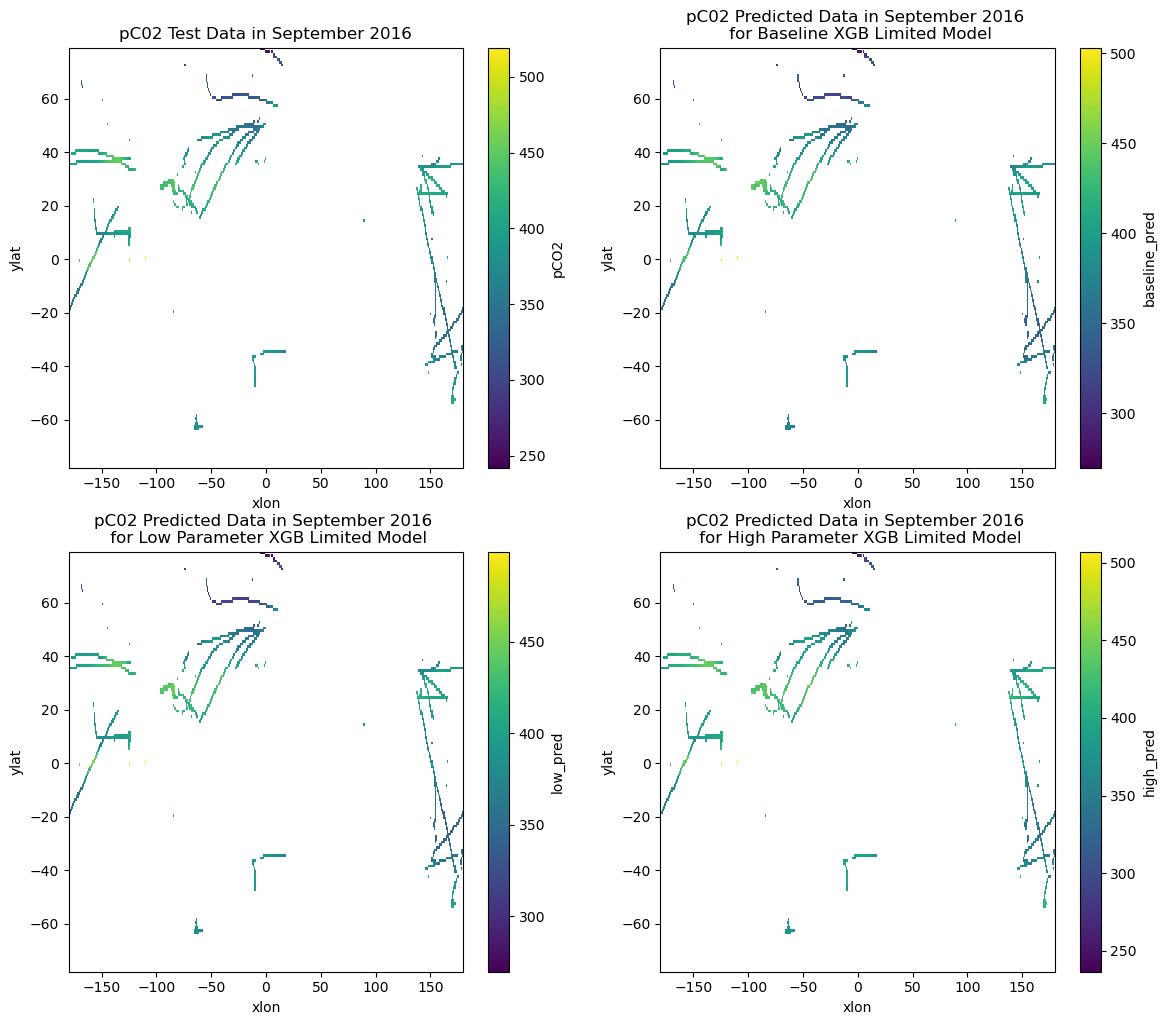

In [86]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(14,12))

y_comparison.sel(time='2016-9-15').pCO2.plot(ax=ax1)
ax1.set_title('pC02 Test Data in September 2016')

y_comparison.sel(time='2016-9-15').baseline_pred.plot(ax=ax2)
ax2.set_title('pC02 Predicted Data in September 2016 \n for Baseline XGB Limited Model')

y_comparison.sel(time='2016-9-15').low_pred.plot(ax=ax3)
ax3.set_title('pC02 Predicted Data in September 2016 \n for Low Parameter XGB Limited Model')

y_comparison.sel(time='2016-9-15').high_pred.plot(ax=ax4)
ax4.set_title('pC02 Predicted Data in September 2016 \n for High Parameter XGB Limited Model')

Text(0.5, 1.0, 'pC02 Bias in September 2016 for High Parameter XGB Limited Model')

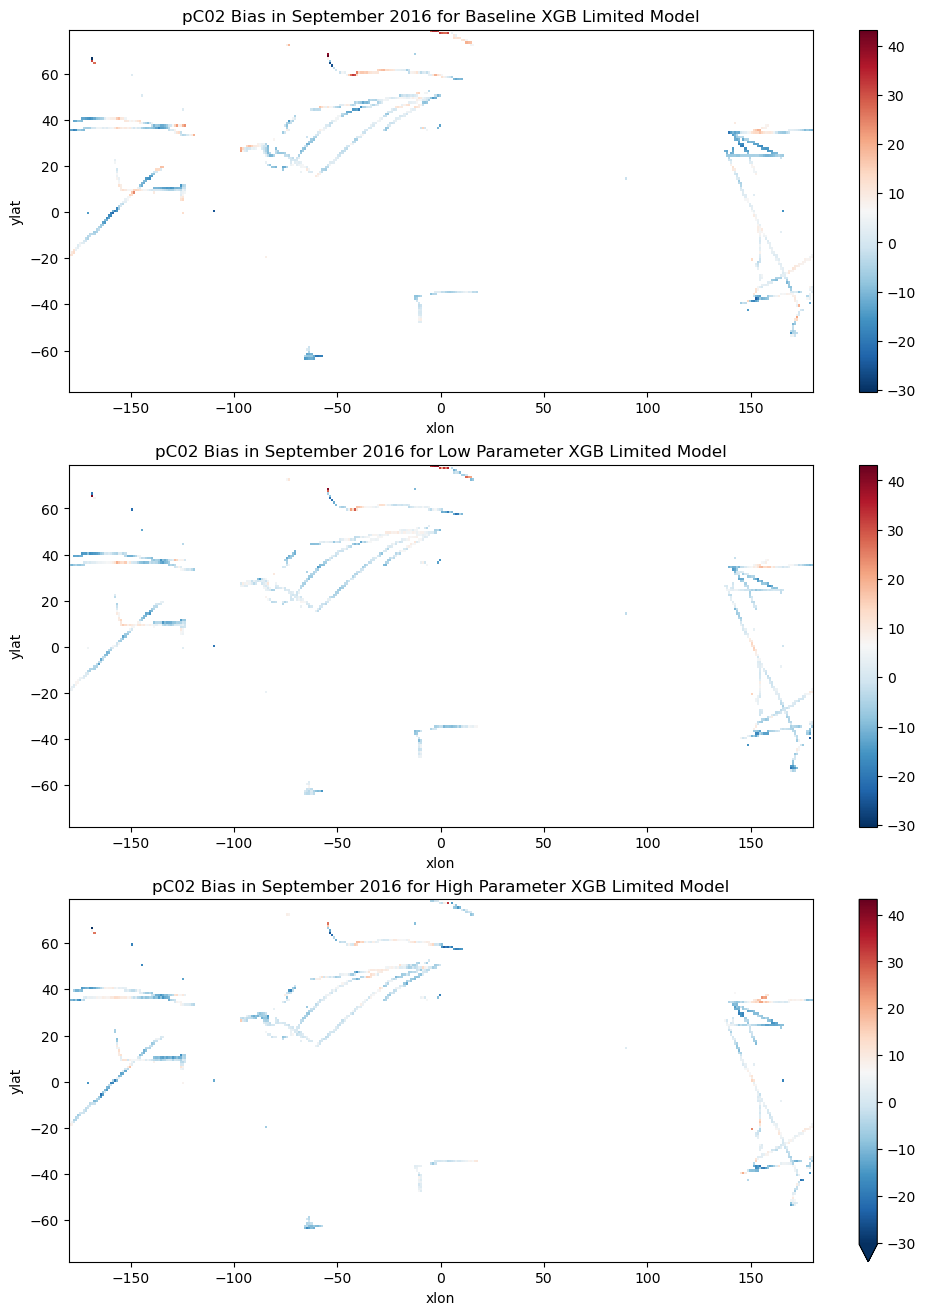

In [87]:
fig, ax = plt.subplots(nrows=3, figsize=(12,16))
selected_time = y_comparison.sel(time='2016-9-15')
test = selected_time.pCO2

unifymin = (selected_time.baseline_pred-selected_time.pCO2).min()
unifymax = (selected_time.baseline_pred-selected_time.pCO2).max()

(selected_time.baseline_pred-selected_time.pCO2).plot(ax=ax[0],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[0].set_title('pC02 Bias in September 2016 for Baseline XGB Limited Model')

(selected_time.low_pred-selected_time.pCO2).plot(ax=ax[1],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[1].set_title('pC02 Bias in September 2016 for Low Parameter XGB Limited Model')

(selected_time.high_pred-selected_time.pCO2).plot(ax=ax[2],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[2].set_title('pC02 Bias in September 2016 for High Parameter XGB Limited Model')

Text(0.5, 1.0, 'Averaged pC02 Bias for High Parameter XGB Limited Model')

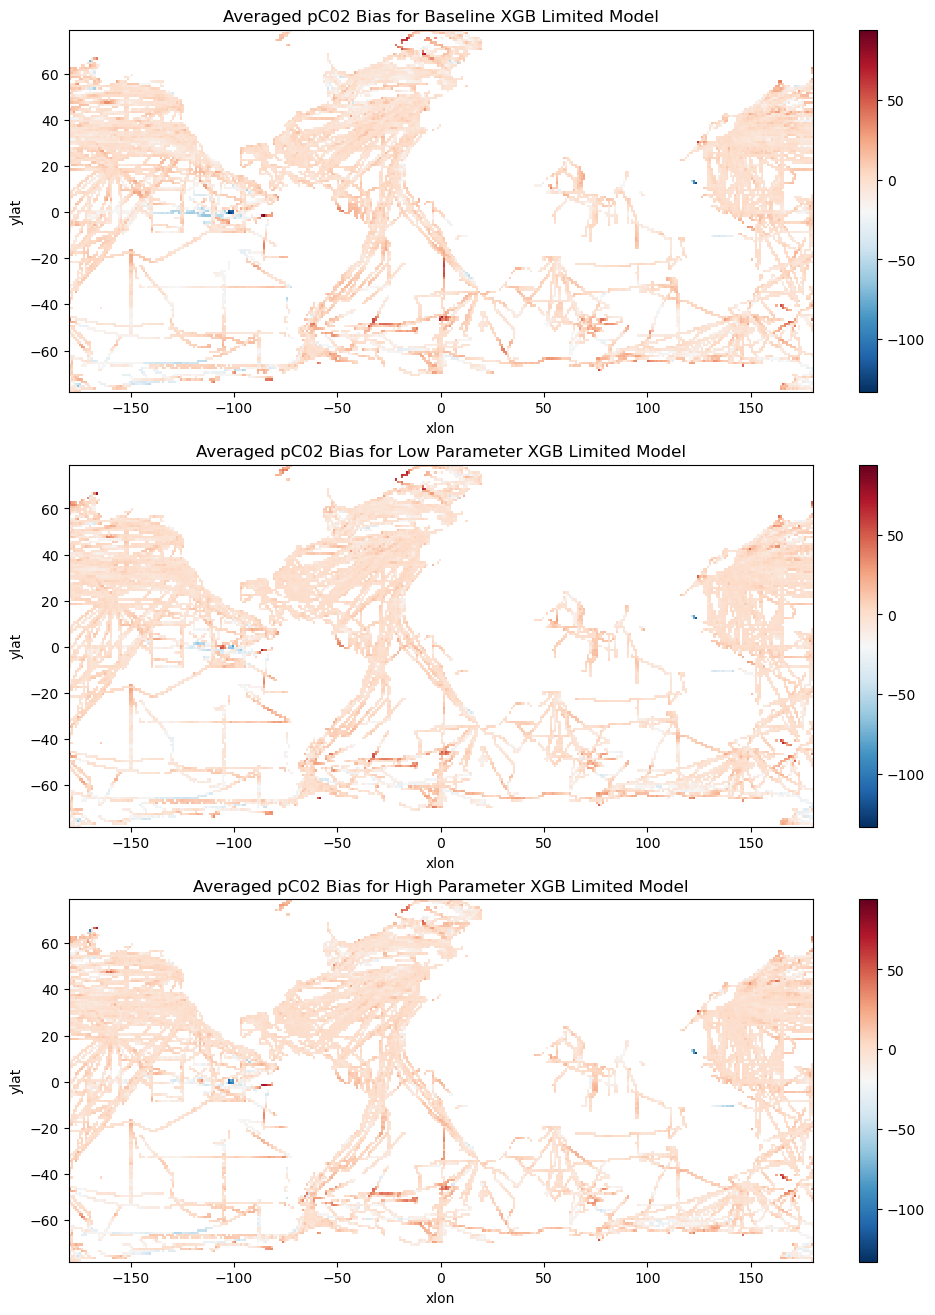

In [88]:
fig, ax = plt.subplots(nrows=3, figsize=(12,16))
avg = y_comparison.mean(dim='time')

unifymin = (avg.baseline_pred-avg.pCO2).min()
unifymax = (avg.baseline_pred-avg.pCO2).max()

(avg.baseline_pred-avg.pCO2).plot(ax=ax[0],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[0].set_title('Averaged pC02 Bias for Baseline XGB Limited Model')

(avg.low_pred-avg.pCO2).plot(ax=ax[1],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[1].set_title('Averaged pC02 Bias for Low Parameter XGB Limited Model')

(avg.high_pred-avg.pCO2).plot(ax=ax[2],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[2].set_title('Averaged pC02 Bias for High Parameter XGB Limited Model')